In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
TIMESERIES = "data/timeseries.csv"

In [3]:
df = pd.read_csv(TIMESERIES, parse_dates=['Date', 'DateIdx'])

In [4]:
len(df)

35040

In [5]:
sum(df.DateIdx == df.Date)

35040

In [6]:
cols = df.columns

In [7]:
cols

Index([u'DateIdx', u'Date', u'VAR', u'dewpti', u'hum', u'pressurei', u'rain',
       u'tempi', u'thunder', u'Day', u'Holiday', u'PCA_1'],
      dtype='object')

In [8]:
df = df[cols[1:]]

In [9]:
df.head()

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1
0,2016-05-01 00:00:00,24.25751,62.30,82.000000,29.960000,0.0,67.500000,0.0,1,0,-15.419709
1,2016-05-01 00:15:00,25.38191,49.85,84.458356,29.832557,0.0,67.257999,0.0,1,0,198.166945
2,2016-05-01 00:30:00,25.10542,62.60,88.000000,29.950000,0.0,66.200000,0.0,1,0,104.502454
3,2016-05-01 00:45:00,24.22065,62.45,85.750000,29.950000,0.0,66.400000,0.0,1,0,119.514737
4,2016-05-01 01:00:00,24.18378,62.30,83.500000,29.950000,0.0,66.600000,0.0,1,0,134.532242


In [10]:
df.describe()

,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1
count,34368.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,3.504000e+04
mean,24.551156,52.720154,61.963899,29.979410,0.076163,66.614993,0.003289,0.287671,0.038356,-2.076472e-16
std,3.791351,11.685180,20.013889,0.290099,0.234463,9.309765,0.050211,0.452683,0.192057,1.059859e+02
min,15.005900,8.800000,6.000000,0.000000,0.000000,42.400000,0.000000,0.000000,0.000000,-1.957965e+02
25%,21.842820,43.550000,47.750000,29.840000,0.000000,60.400000,0.000000,0.000000,0.000000,-9.377721e+01
50%,24.344490,53.800000,63.250000,29.985000,0.000000,66.600000,0.000000,0.000000,0.000000,4.146117e+00
75%,26.856530,62.450000,78.000000,30.120000,0.000000,72.700000,0.000000,1.000000,0.000000,9.444932e+01
max,40.496770,82.400000,100.000000,30.690000,1.000000,105.800000,1.000000,1.000000,1.000000,1.981669e+02


Zmienne:
* rain
* thunder
* Day
* Holiday 

przyjmują wartości dyskretne (binarne).

In [11]:
BINARY_COLS = ['rain', 'thunder', 'Day', 'Holiday']
CONT_COLS = ['dewpti', 'hum', 'pressurei', 'tempi', 'PCA_1']

### Dodatkowe kolumny z czasem

In [12]:
df['month'] = pd.to_datetime(df['Date']).apply(lambda x: x.month)

In [13]:
df['day'] = pd.to_datetime(df['Date']).apply(lambda x: x.day)

In [14]:
df['hour'] = pd.to_datetime(df['Date']).apply(lambda x: x.hour)

In [15]:
df['minute'] = pd.to_datetime(df['Date']).apply(lambda x: x.minute)

### Normalizacja zmiennych ciągłych

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()

In [18]:
df[CONT_COLS] = scaler.fit_transform(df[CONT_COLS].values)

In [19]:
df.head()

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1,month,day,hour,minute
0,2016-05-01 00:00:00,24.25751,0.819840,1.001124,-0.066908,0.0,0.095064,0.0,1,0,-0.145490,5,1,0,0
1,2016-05-01 00:15:00,25.38191,-0.245627,1.123958,-0.506223,0.0,0.069069,0.0,1,0,1.869774,5,1,0,15
2,2016-05-01 00:30:00,25.10542,0.845514,1.300920,-0.101379,0.0,-0.044577,0.0,1,0,0.986017,5,1,0,30
3,2016-05-01 00:45:00,24.22065,0.832677,1.188497,-0.101379,0.0,-0.023094,0.0,1,0,1.127663,5,1,0,45
4,2016-05-01 01:00:00,24.18378,0.819840,1.076073,-0.101379,0.0,-0.001611,0.0,1,0,1.269359,5,1,1,0


In [20]:
FEATURES = df.columns.drop(["Date","VAR"])
GROUND_TRUTH = ["VAR"]

### Przygotowanie danych do sieci rekurencyjnej

In [21]:
def prepare_recurrent_input(df, seq_size=3):
    '''
    
    A function to prepare sequences 
    for recurrent neural network
    
    '''
    df_ret = df.copy()
    
    pad = (seq_size - 1) / 2
    
    cols = df.columns.values.tolist()
    left_cols = []
    right_cols = []
    
    for i in range(pad):
        i += 1
        
        for col in df.columns:
            col_name = "{}_t-{}".format(col, i)
            df_ret[col_name] = df_ret[col].shift(i)
            left_cols.append(col_name)

        for col in df.columns:
            col_name = "{}_t+{}".format(col, i)
            df_ret[col_name] = df_ret[col].shift(-i)
            right_cols.append(col_name)
   
    columns = left_cols[::-1]+cols+right_cols     
    return df_ret[columns]

In [22]:
rec_df = prepare_recurrent_input(df[FEATURES], 11)

In [23]:
rec_df.dropna(inplace=True)

In [24]:
len(df)

35040

In [25]:
len(rec_df)

35030

In [26]:
rec_df.head()

,minute_t-5,hour_t-5,day_t-5,month_t-5,PCA_1_t-5,Holiday_t-5,Day_t-5,thunder_t-5,tempi_t-5,rain_t-5,...,rain_t+5,tempi_t+5,thunder_t+5,Day_t+5,Holiday_t+5,PCA_1_t+5,month_t+5,day_t+5,hour_t+5,minute_t+5
5,0.0,0.0,1.0,5.0,-0.145490,0.0,1.0,0.0,0.095064,0.0,...,0.0,-0.055318,0.0,1.0,0.0,1.127320,5.0,1.0,2.0,30.0
6,15.0,0.0,1.0,5.0,1.869774,0.0,1.0,0.0,0.069069,0.0,...,0.0,-0.082172,0.0,1.0,0.0,1.150979,5.0,1.0,2.0,45.0
7,30.0,0.0,1.0,5.0,0.986017,0.0,1.0,0.0,-0.044577,0.0,...,0.0,-0.109026,0.0,1.0,0.0,1.174584,5.0,1.0,3.0,0.0
8,45.0,0.0,1.0,5.0,1.127663,0.0,1.0,0.0,-0.023094,0.0,...,0.0,-0.173476,0.0,1.0,0.0,1.127309,5.0,1.0,3.0,15.0
9,0.0,1.0,1.0,5.0,1.269359,0.0,1.0,0.0,-0.001611,0.0,...,0.0,-0.237925,0.0,1.0,0.0,1.079982,5.0,1.0,3.0,30.0


### Przekształcanie wejścia

In [27]:
rec_df["VAR"] = df["VAR"].iloc[rec_df.index.values]

In [28]:
train_df = rec_df[~rec_df.VAR.isna()]

In [29]:
test_df = rec_df[rec_df.VAR.isna()]

In [30]:
#plt.figure(figsize=(20,10))
#plt.plot(train_df.VAR)

### Podział datasetu

In [31]:
idx = range(len(train_df))
len(idx)

34363

In [32]:
train_df.shape
231 / 21

11

In [33]:
dev_last_idx = int(0.8 * len(idx))

In [34]:
dev_idx = idx[:dev_last_idx]
dev_test_idx = idx[dev_last_idx:]

### Reshape

In [35]:
# Dane treningowe
X_train = train_df.iloc[:dev_last_idx][train_df.columns[:-1]].values
y_train = train_df.iloc[:dev_last_idx][train_df.columns[-1]].values

In [36]:
X_test = test_df.iloc[:dev_last_idx][test_df.columns[:-1]].values
#y_test = test_df.iloc[:dev_last_idx][test_df.columns[-1]].values

In [37]:
X_train.shape

(27490, 143)

In [38]:
X_train = X_train.reshape(X_train.shape[0], 11, -1).swapaxes(1, 2)
X_test = X_test.reshape(X_test.shape[0], 11, -1).swapaxes(1, 2)

In [39]:
for c in train_df.columns:
    print c

minute_t-5
hour_t-5
day_t-5
month_t-5
PCA_1_t-5
Holiday_t-5
Day_t-5
thunder_t-5
tempi_t-5
rain_t-5
pressurei_t-5
hum_t-5
dewpti_t-5
minute_t-4
hour_t-4
day_t-4
month_t-4
PCA_1_t-4
Holiday_t-4
Day_t-4
thunder_t-4
tempi_t-4
rain_t-4
pressurei_t-4
hum_t-4
dewpti_t-4
minute_t-3
hour_t-3
day_t-3
month_t-3
PCA_1_t-3
Holiday_t-3
Day_t-3
thunder_t-3
tempi_t-3
rain_t-3
pressurei_t-3
hum_t-3
dewpti_t-3
minute_t-2
hour_t-2
day_t-2
month_t-2
PCA_1_t-2
Holiday_t-2
Day_t-2
thunder_t-2
tempi_t-2
rain_t-2
pressurei_t-2
hum_t-2
dewpti_t-2
minute_t-1
hour_t-1
day_t-1
month_t-1
PCA_1_t-1
Holiday_t-1
Day_t-1
thunder_t-1
tempi_t-1
rain_t-1
pressurei_t-1
hum_t-1
dewpti_t-1
dewpti
hum
pressurei
rain
tempi
thunder
Day
Holiday
PCA_1
month
day
hour
minute
dewpti_t+1
hum_t+1
pressurei_t+1
rain_t+1
tempi_t+1
thunder_t+1
Day_t+1
Holiday_t+1
PCA_1_t+1
month_t+1
day_t+1
hour_t+1
minute_t+1
dewpti_t+2
hum_t+2
pressurei_t+2
rain_t+2
tempi_t+2
thunder_t+2
Day_t+2
Holiday_t+2
PCA_1_t+2
month_t+2
day_t+2
hour_t+2
minute_

In [41]:
np.savez("data/rnn_input.npz", X_train=X_train, X_test=X_test, y_train=y_train)

In [42]:
loaded = np.load("data/rnn_input.npz")
loaded['X_train'].shape

(27490, 13, 11)

### LSTM

In [307]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [310]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(13, 11)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [311]:
model.fit(X_train, y_train)

Epoch 1/1
27490/27490 [==============================] - 11s 398us/step - loss: 10.5616

In [30]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [31]:
y_pred = model.predict(X_test)

## Wynik

### RMSE

In [32]:
rmse = np.sqrt(((y_test - y_pred)**2).mean())
rmse

3.2516745650442576

### MAE

In [33]:
mae = np.abs(y_test - y_pred).mean()
mae

2.5983442361293925

### R<sup>2</sup>

In [34]:
y_mean = y_test.mean()
ss_residual = ((y_test - y_pred)**2).sum()
ss_total = ((y_test - y_mean)**2).sum()
R2 = 1 - (ss_residual / ss_total)
R2

0.03157927212167955

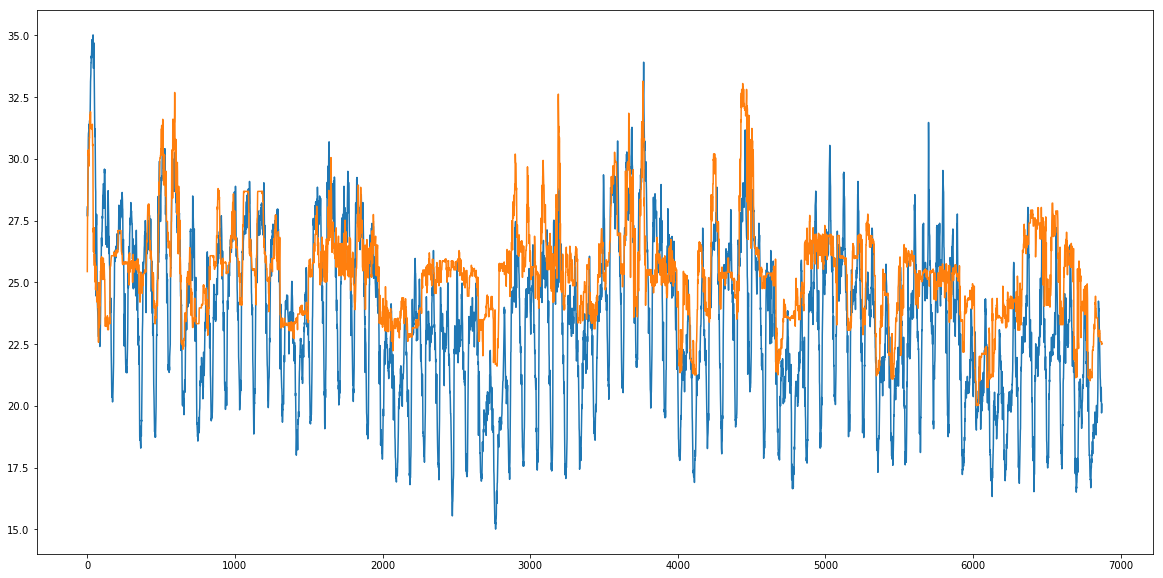

In [35]:
plt.figure(figsize=(20,10))
plt.plot(y_test)
plt.plot(y_pred)